<a href="https://colab.research.google.com/github/JuliethLopez/chatbot_simpsons/blob/master/Clasificador%20frases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación usando Lenguaje Natural

In [0]:
#librerias
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define algunas características iniciales

In [0]:
vocab_size = 2000 # número de palabras que integrarán el vocabulario
embedding_dim = 32 # dimensión del embeding de las palabras
max_length = 120  # longitud máxima de una oración (sentence filtrada con stopwords)
trunc_type='post' # donde truncar una oración (sentence, filtrada con stopwords)
padding_type='post'# donde hacer el padding (agregar ceros) en una oración (sentence, filtrada con stopwords)
oov_tok = "<OOV>"  # token para las palabras que queden fuera del vocabulario
training_portion = .8  # porcentaje de datos para entrenamiento

In [0]:
complete_sentences = []
complete_lines = [] 
sentences = []
labels = [] # preprocesed labels

stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
print(len(stopwords))

153


In [0]:
import string
import numpy as np

a = np.array([32]) # space
#b = np.array(range(65,91)) # uppercase
c = np.array(range(97,123)) # lowercase
printab = np.hstack((a,c))

printable = np.array([chr(i) for i in printab])   
printable

#ascci_to_char = dict((printab[i], printable[i]) for i in range(len(printable)))

array([' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
       'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y',
       'z'], dtype='<U1')

In [0]:
#lectura de los datos
import string
import re #regular expresions
# abre el archivo de datos y lo trata como un archivo csv
file = open('DFSMS.csv', 'r')
with file as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        # preprocess label
        #label_l = ' '.join(row[0].split()).lower().replace(' ','_') # lower case ans eliminate multiple spaces
        label_l = re.sub(' +', ' ',row[0].lower()) # lower case ans eliminate multiple spaces
        if (len(label_l)>2): # drop with empty label
            label = ''.join(c for c in label_l if c in printable)# filter only printable characters
            label = label.replace(' ','_')
            labels.append(label)
            # preprocess sentence
            #sentence_l = ' '.join(row[1].split()).lower().replace(' ','_') # lower case ans eliminate multiple spaces
            sentence_l = re.sub(' +', ' ',row[1].lower())
            sentence = ''.join(c for c in sentence_l if c in printable)
            complete_lines.append(row[0] + ': '+ row[1])
            complete_sentences.append(sentence)
            # preprocess stopwords
            for word in stopwords:
                token = " " + word + " "
                sentence = sentence.replace(token, " ")
            sentences.append(sentence)
 

# resumen de la lectura            
print(len(labels))
print(len(complete_sentences))
print(len(complete_lines))
print(len(sentences))
# Expected Output
# 158314

105304
105304
105304
105304


In [0]:
# primera linea
print(labels[0]+'\n')
print(complete_sentences[0]+'\n')
print(complete_lines[0]+'\n')
print(sentences[0]+'\n')
# Expected Output
# 158314
# 158314

lisa_simpson

wheres mr bergstrom

Lisa Simpson: Where's Mr. Bergstrom?

wheres mr bergstrom



In [0]:
sentences[:4]

['wheres mr bergstrom',
 'that life worth living',
 'the polls will open now end recess now just case decided put thought well final statements martin',
 'i dont think theres anything left say']

# Separa datos de entrenamiento y validación 

In [0]:
train_size = int(len(sentences) * training_portion)

train_sentences = sentences[:train_size]
train_labels = labels[:train_size]

validation_sentences = sentences[train_size:]
validation_labels = labels[train_size:]

print(train_size)
print(len(train_sentences))
print(len(train_labels))
print(len(validation_sentences))
print(len(validation_labels))

# Expected output (if training_portion=.8)
# 126651 train
# 31663 validation

84243
84243
84243
21061
21061


In [0]:
train_sentences[:3]

['wheres mr bergstrom',
 'that life worth living',
 'the polls will open now end recess now just case decided put thought well final statements martin']

In [0]:
train_labels[:3]

['lisa_simpson', 'lisa_simpson', 'edna_krabappelflanders']

# crea el vocabulario

In [0]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok,split= ' ')
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = np.array(pad_sequences(train_sequences, padding=padding_type, maxlen=max_length))

In [0]:
print((train_sequences[0]))
print(len(train_padded[0]))

#print(len(train_sequences[1]))
#print(len(train_padded[1]))

#print(len(train_sequences[10]))
#print(len(train_padded[10]))

# Expected Ouput
# 12
# 120
# 3
# 120
# 10
# 120

[339, 86, 1]
120


In [0]:
train_sequences[:2]

[[339, 86, 1], [53, 105, 762, 585]]

In [0]:
train_padded[:2]

array([[339,  86,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [ 53, 105, 762, 585,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,

In [0]:
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = np.array(pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length))


In [0]:
validation_sequences[:2]

# Expected output
# 31663
# (31663, 120)

[[1211, 1066, 1, 1297, 13, 687], [6, 240, 45, 404]]

In [0]:
validation_padded[:2]

array([[1211, 1066,    1, 1297,   13,  687,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   6,  240,   45,  404,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,

In [0]:
print(len(validation_sequences))
print(validation_padded.shape)

# Expected output
# 31663
# (31663, 120)

21061
(21061, 120)


In [0]:
label_size = 500
#filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
label_tokenizer = Tokenizer(num_words = label_size,oov_token=oov_tok, filters = '')
label_tokenizer.fit_on_texts(labels)

label_seq = np.array(label_tokenizer.texts_to_sequences(labels))
training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq[3])
print(training_label_seq[5])
print(training_label_seq.shape)

print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq[3])
print(validation_label_seq[5])
print(validation_label_seq.shape)

# Expected output
# [4]
# [2]
# [1]
# (1780, 1)
# [5]
# [4]
# [3]
# (445, 1)

[5]
[5]
[20]
[34]
[4]
(84243, 1)
[22]
[2]
[2]
[2]
[2]
(21061, 1)


In [0]:
# flatten the nested list and tranaform to an np array
label_seq = np.array([item for items in label_seq for item in items])
training_label_seq = np.array([item for items in training_label_seq for item in items])
validation_label_seq = np.array([item for items in validation_label_seq for item in items])


In [0]:
label_seq[:5]

array([ 5,  5, 20, 34, 20])

In [0]:
max(validation_label_seq)

47

# transform target to one-hot codification

## primero crea etiquetas numéricas

In [0]:
from sklearn. preprocessing import LabelEncoder
#preprocessing.LabelEncoder()
encoder = LabelEncoder()

encoder.fit(label_seq)
y_train = encoder.transform(training_label_seq)
y_test = encoder.transform(validation_label_seq)

In [0]:
max(y_train)

45

In [0]:
y_train.shape

(84243,)

In [0]:
y_train

array([ 3,  3, 18, ..., 38,  2, 23])

In [0]:
y_test

array([20,  0,  0, ...,  3,  3, 27])

## one hot

In [0]:
# Converts the labels to a one-hot representation
num_classes = np.max(y_train) + 1
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [0]:
num_classes

46

In [0]:
y_train.shape

(84243, 46)

In [0]:
y_train[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [0]:
y_test[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

## Modelo 1

| dropout | conv1D | LSTM | accuracyTrain | accuracyValidation | epoch |
|---------|:------:|:----:|:-------------:|:------------------:|:-----:|
|         |        |      |    0.3645     |       0.3478       |  13   |
|    1    |   1    |      |    0.3751     |       0.3462       |  11   |
|         |   1    |      |    0.3761     |       0.3455       |  10   |
|    1    |        |      |    0.3668     |       0.3527       |  15   |
|    1    |        |   1  |    0.3730     |       0.3416       |  13   |

## Modelo 2 con 9 Labels

| spatial Dropout1d | BIDLSTM | Dropout | Dense | lossTrain |accuracyTrain | accuracyValidation | lossValidation  | epoch |
|::|::|::|::|::|::|::|::|::|
|1|2|2|2|1.2943|0.5236|1.5963|0.4304|23|



In [0]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', patience=3
    )
# This callback will stop the training when there is no improvement in
# the validation loss for three consecutive epochs.

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(120, return_sequences=True)),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    #tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(46, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 32)           64000     
_________________________________________________________________
conv1d (Conv1D)              (None, 116, 128)          20608     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 46)                5934      
Total params: 107,054
Trainable params: 107,054
Non-trainable params: 0
_________________________________________________________________


## Entrenamos el modelo

In [0]:
num_epochs = 20
history = model.fit(train_padded, y_train, epochs=num_epochs, validation_data=(validation_padded, y_test), verbose=2, callbacks=[callback])
print("\nEn la epoca", len(history.history['val_accuracy']), "la precision de validación dejó de mejorar.")

Epoch 1/20
2633/2633 - 11s - loss: 2.6621 - accuracy: 0.2807 - val_loss: 2.5572 - val_accuracy: 0.2935
Epoch 2/20
2633/2633 - 11s - loss: 2.5474 - accuracy: 0.3005 - val_loss: 2.4812 - val_accuracy: 0.3095
Epoch 3/20
2633/2633 - 11s - loss: 2.4755 - accuracy: 0.3152 - val_loss: 2.4475 - val_accuracy: 0.3189
Epoch 4/20
2633/2633 - 11s - loss: 2.4180 - accuracy: 0.3329 - val_loss: 2.4038 - val_accuracy: 0.3373
Epoch 5/20
2633/2633 - 11s - loss: 2.3704 - accuracy: 0.3499 - val_loss: 2.3795 - val_accuracy: 0.3500
Epoch 6/20
2633/2633 - 11s - loss: 2.3393 - accuracy: 0.3570 - val_loss: 2.3678 - val_accuracy: 0.3494
Epoch 7/20
2633/2633 - 11s - loss: 2.3157 - accuracy: 0.3627 - val_loss: 2.3618 - val_accuracy: 0.3527
Epoch 8/20
2633/2633 - 11s - loss: 2.2936 - accuracy: 0.3670 - val_loss: 2.3622 - val_accuracy: 0.3543
Epoch 9/20
2633/2633 - 11s - loss: 2.2730 - accuracy: 0.3708 - val_loss: 2.3642 - val_accuracy: 0.3454
Epoch 10/20
2633/2633 - 11s - loss: 2.2538 - accuracy: 0.3753 - val_loss:

## Graficamos

In [0]:
string='accuracy'
print(history.history[string])
print(history.history['val_'+string])

[0.28069987893104553, 0.30049973726272583, 0.31515970826148987, 0.33285850286483765, 0.34989258646965027, 0.35696732997894287, 0.36265328526496887, 0.3669503629207611, 0.3707845211029053, 0.3753190040588379, 0.3800315856933594]
[0.29348084330558777, 0.30948197841644287, 0.3188832402229309, 0.3372584283351898, 0.3499833941459656, 0.34936612844467163, 0.35268980264663696, 0.35425668954849243, 0.34537771344184875, 0.3475618362426758, 0.3509804904460907]


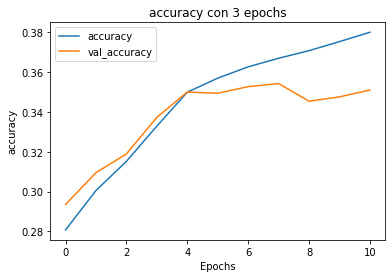

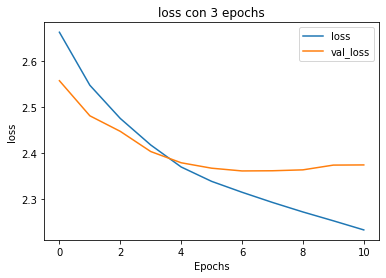

In [0]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.title(string+' con 3 epochs')
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [0]:
#convierte palabras en texto (NO LO USAMOS AÚN)
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

decode_sentence([862, 54])

'table really'

In [0]:
#Pesos de la primera capa
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

# Expected output
# (1000, 16)

(2000, 32)


In [0]:
weights

array([[ 0.00468641, -0.02910699,  0.01675976, ..., -0.04058117,
        -0.02734958,  0.01446591],
       [ 0.01077439, -0.07799715, -0.10403845, ...,  0.04110619,
        -0.02028334, -0.09977639],
       [ 0.00737624,  0.03177939,  0.2815132 , ..., -0.00535306,
         0.0448391 , -0.11029624],
       ...,
       [-0.40208772,  0.00440321, -0.30242747, ...,  0.12172801,
         0.20350999, -0.29364464],
       [-0.15871577, -0.10378639, -0.08309346, ..., -0.18912454,
         0.15142325, -0.09261275],
       [-0.0076654 ,  0.6184703 ,  0.3332991 , ..., -0.32560292,
        -0.13815536,  0.19427721]], dtype=float32)

## funcion clasificadora

In [0]:
validation_sentences[:2]

['keys duff brewery whered get those', 'well might time when']

In [0]:
sq = model.predict_classes(validation_padded[:2])
sq

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([0, 1])

In [0]:
label_tokenizer.sequences_to_texts([sq])

['<OOV> <OOV>']

In [0]:
def classifier (sentence): 
  sentences = []
  sentence_l = re.sub(' +', ' ',sentence.lower())
  sentence = ''.join(c for c in sentence_l if c in printable)
  # preprocess stopwords
  for word in stopwords:
    token = " " + word + " "
    sentence = sentence.replace(token, " ")
  sentences.append(sentence)

  sentences = tokenizer.texts_to_sequences(sentences) #transforms each text in texts to a sequence of integers
  sentences_padded = np.array(pad_sequences(sentences, padding=padding_type, maxlen=max_length))

  #prob = model.predict(sentences_padded)
  prediction = model.predict_classes(sentences_padded)
  prediction = label_tokenizer.sequences_to_texts([prediction])

  return prediction

In [0]:
classifier('are you sure lord')

['<OOV>']

In [0]:
classifier('can his funeral be on a school day')

['homer_simpson']

In [0]:
classifier("We should go to the bar")

['<OOV>']

## exportar archivos

In [0]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [0]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

## Referencias
- Aprendizaje profundo, [Ciencia de datos](https://github.com/AprendizajeProfundo/Ciencia-de-Datos/tree/master/Cuadernos)